In [97]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d as interp
from scipy.integrate import odeint as oi
from scipy.optimize import minimize as me
from matplotlib import pyplot as plt

In [98]:
data = pd.read_csv("100nmoa1h.csv")
data.columns = ["a1", "c2", "b2"]
data = data[["a1", "b2", "c2"]]
max=data.max()*1.1
data = data/max
rat_var = 0.9
a1_og = np.array(data['a1'].to_list())
b2_og = np.array(data['b2'].to_list())
c2_og = np.array(data['c2'].to_list())

t_og = np.arange(0, a1_og.size)
t = np.arange(0, a1_og.size-1, 0.01)

kind = 'cubic'
a1_f = interp(t_og, a1_og, kind = kind)
b2_f = interp(t_og, b2_og, kind = kind)
c2_f = interp(t_og, c2_og, kind = kind)

a1 = a1_f(t)
a2 = 1-a1
b2 = b2_f(t)
b1 = 1-b2
c2 = c2_f(t)
c1 = 1-c2

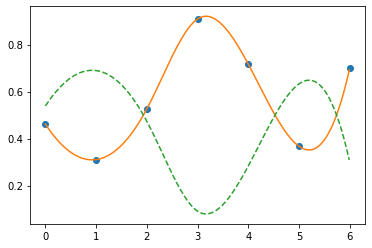

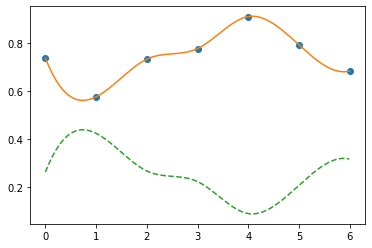

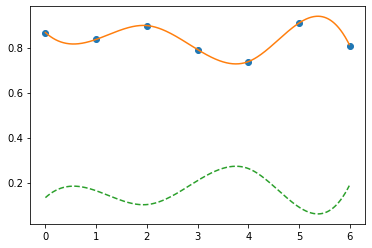

In [99]:
plt.plot(t_og, a1_og, 'o', t, a1, '-', t, a2, '--')
plt.show()
plt.plot(t_og, b2_og, 'o', t, b2, '-', t, b1, '--')
plt.show()
plt.plot(t_og, c2_og, 'o', t, c2, '-', t, c1, '--')
plt.show()

In [141]:
def model(x, t, p):
    
    a1 = x[0]
    a2 = x[1]
    b1 = x[2]
    b2 = x[3]
    c1 = 0.1
    c2 = 0.9
    
    k1 = 1.5
    k1m = 0.015
    k2 = 0.15
    k2m = 0.15
    k3 = 0.15
    k3m = 0.15

    kimtor1 = p[0]
    kimtor2 = p[1]
    kaulk1 = p[2]
    kaulk2 = p[3]
    #kapp21 = p[4]
    #kapp22 = p[5]
    
    da1dt = k1*a2-k1m*a1-kimtor1*a1*b1-kimtor2*a1*c1
    da2dt = k1m*a1-k1*a2+kimtor1*a1*b1+kimtor2*a1*c1
    db1dt = k2*b2-k2m*b1+kaulk1*b2*c1-kaulk2*b1*a1
    db2dt = k2m*b1-k2*b2-kaulk1*b2*c1+kaulk2*b1*a1
    #dc1dt = k3*c2-k3m*c1+kapp21*c2*b1-kapp22*c1*a1
    #dc2dt = k3m*c1-k3*c2-kapp21*c2*b1+kapp22*c1*a1
    
    #dxdt = [da1dt, da2dt, db1dt, db2dt, dc1dt, dc2dt]
    dxdt = [da1dt, da2dt, db1dt, db2dt]
    
    return dxdt

z_meas = np.array([a1, a2, b1, b2, c1, c2])
z_meas_rap = z_meas[0:-2]

def loss_function(p, z_meas_rap, t):
    
    z0 = [a1[0], a2[0], b1[0], b2[0]]
    z = oi(model, z0, t, args=(p,)).T
    
    error = np.sum((z_meas_rap-z)**2)/len(t)
    
    return error

p = np.array([1,1,2.84950074,  9.7170417])

loss_function(p, z_meas_rap, t)

0.35853884020791754

In [142]:
minvar = 0.01
maxvar = None
defb = (minvar, maxvar)
options = {'maxiter' : 100000,
           'disp' : True}
#bounds = [defb, defb, defb, defb, defb, defb, defb, defb, defb, defb, defb, defb]
bounds = [defb, defb, defb, defb]

res = me(loss_function, p, args=(z_meas_rap, t,), method='L-BFGS-B', tol=1e-6, bounds=bounds, options=options)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58539D-01    |proj g|=  5.88353D-02

At iterate    1    f=  3.53777D-01    |proj g|=  5.77157D-02

At iterate    2    f=  1.38314D-01    |proj g|=  1.15922D-02

At iterate    3    f=  1.19572D-01    |proj g|=  9.39988D-03

At iterate    4    f=  1.14498D-01    |proj g|=  4.18005D-03

At iterate    5    f=  1.10346D-01    |proj g|=  5.28879D-03

At iterate    6    f=  1.02946D-01    |proj g|=  5.98057D-03

At iterate    7    f=  1.00218D-01    |proj g|=  4.03345D-03

At iterate    8    f=  9.97715D-02    |proj g|=  2.34169D-03

At iterate    9    f=  9.95812D-02    |proj g|=  2.74347D-04

At iterate   10    f=  9.95711D-02    |proj g|=  2.25224D-04

At iterate   11    f=  9.95354D-02    |proj g|=  2.80520D-04

At iterate   12    f=  9.93881D-02    |proj g|=  6.01669D-04

At iterate   13    f=  9.8

In [143]:
res

      fun: 0.09672924406118623
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.27897693e-05,  2.91749958e-04,  3.53786445e-05, -5.60648747e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 32
     njev: 48
   status: 0
  success: True
        x: array([5.16922716, 0.01      , 0.29018228, 0.96025801])

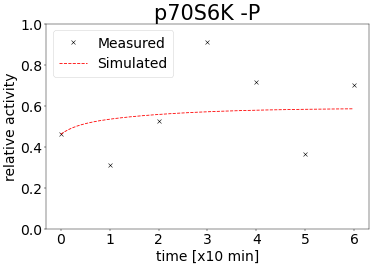

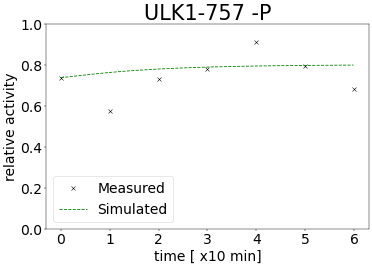

In [159]:
IC = [a1[0], a2[0], b1[0], b2[0]]
params = res.x

z = oi(model, IC, t, args=(params,)).T

font = 25
title = 'oaParam_est'

plt.ylim(0,1)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rcParams["figure.figsize"] = [10.4, 6.8]
plt.rcParams["figure.dpi"] = 40
plt.rcParams["figure.facecolor"]=(1,1,1)

plt.title('p70S6K -P', fontsize=font*1.5)
plt.xlabel('time [x10 min]', fontsize=font)
plt.ylabel('relative activity', fontsize=font)
plt.plot(t_og, a1_og, 'x',color='black',label='Measured')
plt.plot(t, z[0], 'r--',label='Simulated')
plt.legend()
plt.legend(fontsize=font)
plt.savefig('oa_est_p70')
plt.show()

plt.ylim(0,1)
plt.title('ULK1-757 -P',fontsize=font*1.5)
plt.xlabel('time [ x10 min]',fontsize=font)
plt.ylabel('relative activity',fontsize=font)
plt.plot(t_og, b2_og, 'x', color='black',label='Measured')
plt.plot(t, z[3], 'g--', label='Simulated')
plt.legend(fontsize=font)
plt.savefig('oa_ulk_est')
plt.show()